# 🧹 Data Cleaning & Preprocessing

This notebook handles all data cleaning and preprocessing steps to prepare the dataset for analysis.

## 🎯 Objectives
- Split composite columns (city_state)
- Transform flag columns to proper format
- Handle multi-value fuel_type column
- Remove duplicates and invalid readings
- Create derived features (lead flags)
- Save cleaned dataset

In [14]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
from src.data.data_loader import load_raw_data, basic_data_info, save_processed_data

## 📊 Load Data

In [15]:
# Load the raw data
df_raw = load_raw_data(file_path='../../data/raw/raw_data.csv')
print(f"📊 Original dataset shape: {df_raw.shape}")
print(f"📋 Original columns: {len(df_raw.columns)}")

2025-08-07 14:07:27,888 - src.data.data_loader - INFO - Successfully loaded 48665 rows from ../../data/raw/raw_data.csv


📊 Original dataset shape: (48665, 41)
📋 Original columns: 41


## 🏙️ Step 1: Split City and State

In [16]:
# Create a copy for processing
df_processed = df_raw.copy()

print("🏙️ Splitting city_state column...")
print(f"Original city_state sample: {df_processed['city_state'].head(3).tolist()}")

# Split city_state into separate city and state columns
for _, row in df_processed.iterrows():
    str_cs = row['city_state']
    cs_ = str_cs.split('_')
    df_processed.at[_, "city"] = cs_[1].strip()
    df_processed.at[_, "state"] = cs_[0].strip()

# Function to fix encoding issues in text columns
def fix_encoding(text):
    if isinstance(text, str):
        try:
            return (
                text
                .encode('latin1', errors='replace')
                .decode('utf-8', errors='replace')
            )
        except:
            return text
    return text

# Fix encoding issues
df_processed['city'] = df_processed['city'].apply(fix_encoding)

# Drop the original city_state column
df_processed.drop(columns=['city_state'], inplace=True)

print(f"✅ Created 'city' and 'state' columns")
print(f"📊 Unique states: {df_processed['state'].nunique()}")
print(f"🏘️ Unique cities: {df_processed['city'].nunique()}")
print(f"📍 Sample cities: {df_processed['city'].head(5).tolist()}")
print(f"🗺️ Sample states: {df_processed['state'].unique()[:10].tolist()}")

🏙️ Splitting city_state column...
Original city_state sample: ['GO_Itumbiara', 'SP_Osasco', 'SP_SÃ£o Paulo']
✅ Created 'city' and 'state' columns
📊 Unique states: 28
🏘️ Unique cities: 959
📍 Sample cities: ['Itumbiara', 'Osasco', 'São Paulo', 'São Paulo', 'São Paulo']
🗺️ Sample states: ['GO', 'SP', 'RS', 'MG', 'DF', 'RJ', 'PI', 'PA', 'PR', 'SC']
✅ Created 'city' and 'state' columns
📊 Unique states: 28
🏘️ Unique cities: 959
📍 Sample cities: ['Itumbiara', 'Osasco', 'São Paulo', 'São Paulo', 'São Paulo']
🗺️ Sample states: ['GO', 'SP', 'RS', 'MG', 'DF', 'RJ', 'PI', 'PA', 'PR', 'SC']


## 🏷️ Step 2: Transform Flag Columns

In [17]:
print("🏷️ Processing flag columns...")

# Find all flag columns
flag_columns = [col for col in df_processed.columns if col.startswith("flg_")]
print(f"📊 Found {len(flag_columns)} flag columns")

# Show sample values before transformation
if flag_columns:
    sample_col = flag_columns[0]
    print(f"\n📋 Sample values in '{sample_col}' before transformation:")
    print(df_processed[sample_col].value_counts())

# Transform flag columns
for col in flag_columns:
    df_processed[col] = df_processed[col].fillna(0)
    df_processed[col] = df_processed[col].replace({"S": "Y"}).replace({"Y": 1, "N": 0}).astype(int)

# Show sample values after transformation
if flag_columns:
    print(f"\n📋 Sample values in '{sample_col}' after transformation:")
    print(df_processed[sample_col].value_counts())

print(f"\n✅ Transformed {len(flag_columns)} flag columns to integers")

🏷️ Processing flag columns...
📊 Found 21 flag columns

📋 Sample values in 'flg_single_owner' before transformation:
flg_single_owner
0    38587
1    10078
Name: count, dtype: int64

📋 Sample values in 'flg_single_owner' after transformation:
flg_single_owner
0    38587
1    10078
Name: count, dtype: int64

✅ Transformed 21 flag columns to integers

📋 Sample values in 'flg_single_owner' after transformation:
flg_single_owner
0    38587
1    10078
Name: count, dtype: int64

✅ Transformed 21 flag columns to integers


## ⛽ Step 3: Handle Fuel Type Multi-Values

## 🗑️ Step 4: Remove Duplicates

In [18]:
print("🗑️ Removing duplicate rows...")
original_shape = df_processed.shape
df_processed = df_processed.drop_duplicates().reset_index(drop=True)
new_shape = df_processed.shape

duplicates_removed = original_shape[0] - new_shape[0]
print(f"📊 Original shape: {original_shape}")
print(f"📊 New shape: {new_shape}")
print(f"🗑️ Duplicates removed: {duplicates_removed:,} rows ({duplicates_removed/original_shape[0]*100:.2f}%)")

🗑️ Removing duplicate rows...
📊 Original shape: (48665, 42)
📊 New shape: (48665, 42)
🗑️ Duplicates removed: 0 rows (0.00%)
📊 Original shape: (48665, 42)
📊 New shape: (48665, 42)
🗑️ Duplicates removed: 0 rows (0.00%)


## 🧹 Step 5: Clean Spurious Readings

In [19]:
print("🧹 Cleaning spurious readings (-1 values)...")
original_shape = df_processed.shape

# Check how many rows have -1 values
rows_with_minus_one = (df_processed == -1).any(axis=1).sum()
print(f"📊 Rows with -1 values: {rows_with_minus_one:,} ({rows_with_minus_one/len(df_processed)*100:.2f}%)")

# Remove rows with -1 values
df_processed = df_processed[~(df_processed == -1).any(axis=1)].reset_index(drop=True)
new_shape = df_processed.shape

spurious_removed = original_shape[0] - new_shape[0]
print(f"📊 Original shape: {original_shape}")
print(f"📊 New shape: {new_shape}")
print(f"🗑️ Spurious readings removed: {spurious_removed:,} rows ({spurious_removed/original_shape[0]*100:.2f}%)")

🧹 Cleaning spurious readings (-1 values)...
📊 Rows with -1 values: 2 (0.00%)
📊 Original shape: (48665, 42)
📊 New shape: (48663, 42)
🗑️ Spurious readings removed: 2 rows (0.00%)
📊 Original shape: (48665, 42)
📊 New shape: (48663, 42)
🗑️ Spurious readings removed: 2 rows (0.00%)


## 🎯 Step 6: Create Lead Flag Column

In [20]:
print("🎯 Creating lead flag column...")

# Create binary lead flag
df_processed['flg_leads'] = df_processed['leads'].apply(lambda x: 1 if x > 0 else 0)

# Analyze the target distribution
lead_distribution = df_processed['flg_leads'].value_counts(normalize=True)
print(f"\n📊 Lead Flag Distribution:")
print(f"  - No leads (0): {lead_distribution[0]:.1%}")
print(f"  - Has leads (1): {lead_distribution[1]:.1%}")

# Original leads distribution
print(f"\n📈 Original 'leads' column statistics:")
print(f"  - Mean: {df_processed['leads'].mean():.2f}")
print(f"  - Median: {df_processed['leads'].median():.2f}")
print(f"  - Max: {df_processed['leads'].max()}")
print(f"  - Min: {df_processed['leads'].min()}")

print(f"\n✅ Created 'flg_leads' binary column")

🎯 Creating lead flag column...

📊 Lead Flag Distribution:
  - No leads (0): 21.9%
  - Has leads (1): 78.1%

📈 Original 'leads' column statistics:
  - Mean: 4.42
  - Median: 1.00
  - Max: 364
  - Min: 0

✅ Created 'flg_leads' binary column
  - Median: 1.00
  - Max: 364
  - Min: 0

✅ Created 'flg_leads' binary column


## Step 7: Outlier Treatment

In [21]:
### Outlier Treatment
def remove_outliers_iqr(df, columns, lower_percentile=0.01, upper_percentile=0.99, k=3):
    """Remove outliers using percentile-based approach"""
    df_processed_outliers = df.copy()
    
    for col in columns:
        q_low = df[col].quantile(lower_percentile)
        q_high = df[col].quantile(upper_percentile)
        q1 = df[col].quantile(0.01)
        q3 = df[col].quantile(0.995)
        iqr = q_high - q_low
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        outliers_low = (df_processed_outliers[col] < lower).sum()
        outliers_high = (df_processed_outliers[col] > upper).sum()
        total_outliers = outliers_low + outliers_high
        
        print(f"{col}:")
        print(f"  - Lower bound ({lower_percentile:.1%}): {lower:.2f} ({outliers_low} outliers)")
        print(f"  - Upper bound ({upper_percentile:.1%}): {upper:.2f} ({outliers_high} outliers)")
        print(f"  - Total outliers: {total_outliers} ({total_outliers/len(df)*100:.2f}%)")
        
        df_processed_outliers = df_processed_outliers[
            (df_processed_outliers[col] >= lower) & (df_processed_outliers[col] <= upper)
        ]
        print(f"  - Rows removed: {len(df) - len(df_processed_outliers)}\n")
        
    return df_processed_outliers

print("🧹 Outlier Analysis and Removal:")
print(f"Original dataset shape: {df_processed.shape}")
print("\nOutlier statistics by feature:")

df_no_outliers = remove_outliers_iqr(df_processed, ["vl_advertise", "km_vehicle"])

print(f"\n📊 After outlier removal:")
print(f"New dataset shape: {df_no_outliers.shape}")
outliers_removed = len(df_processed) - len(df_no_outliers)
print(f"Rows removed: {outliers_removed:,} ({outliers_removed/len(df_processed)*100:.2f}%)")

🧹 Outlier Analysis and Removal:
Original dataset shape: (48663, 43)

Outlier statistics by feature:
vl_advertise:
  - Lower bound (1.0%): -816139.08 (0 outliers)
  - Upper bound (99.0%): 1217024.66 (46 outliers)
  - Total outliers: 46 (0.09%)
  - Rows removed: 46

km_vehicle:
  - Lower bound (1.0%): -810000.00 (0 outliers)
  - Upper bound (99.0%): 1809999.00 (39 outliers)
  - Total outliers: 39 (0.08%)
  - Rows removed: 85


📊 After outlier removal:
New dataset shape: (48578, 43)
Rows removed: 85 (0.17%)


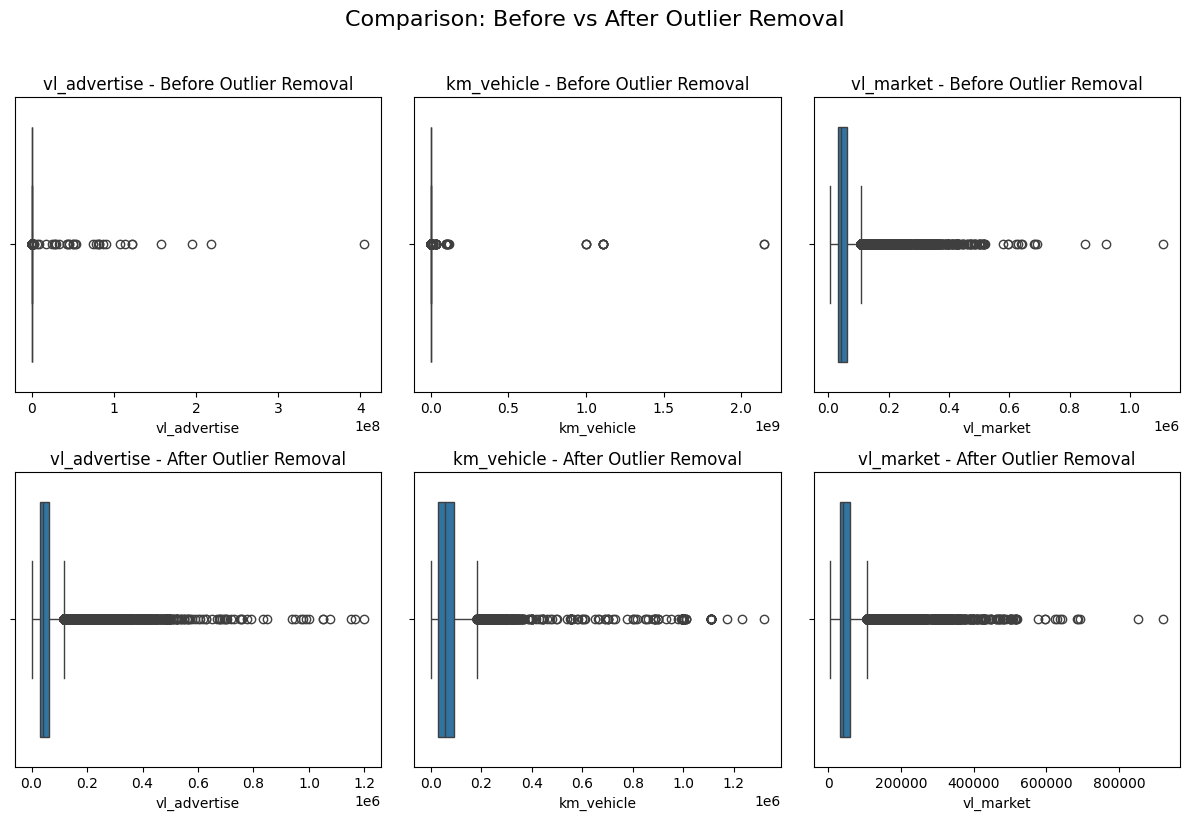

✅ Updated main dataset with outlier removal: (48578, 43)


In [22]:

# Compare distributions before and after outlier removal
numeric_cols = [
 'vl_advertise',
 'km_vehicle',
 'vl_market',
 ]
n_features = len(numeric_cols)
fig, axes = plt.subplots(2, n_features, figsize=(4*n_features, 8))
if n_features == 1:
    axes = axes.reshape(2, 1)

for i, col in enumerate(numeric_cols):
    # Before outlier removal
    sns.boxplot(data=df_processed, x=col, ax=axes[0, i])
    axes[0, i].set_title(f'{col} - Before Outlier Removal')
    
    # After outlier removal
    sns.boxplot(data=df_no_outliers, x=col, ax=axes[1, i])
    axes[1, i].set_title(f'{col} - After Outlier Removal')

plt.suptitle('Comparison: Before vs After Outlier Removal', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Update the main dataset
df_processed = df_no_outliers.copy()
print(f"✅ Updated main dataset with outlier removal: {df_processed.shape}")

## Step 8: Fuel type expansion into binary flags

In [23]:
print("⛽ Processing fuel_type column...")
print(f"📊 Original fuel_type unique values:")
unique_fuel_types = df_processed.fuel_type.unique()
for fuel in unique_fuel_types[:10]:  # Show first 10
    print(f"  - '{fuel}'")
if len(unique_fuel_types) > 10:
    print(f"  ... and {len(unique_fuel_types) - 10} more")

# Extract all unique fuel types from the multi-value strings
fuel_types = []
for item in df_processed.fuel_type.unique():
    if isinstance(item, str):  # check if item is a string
        # Split the string by spaces and commas, and strip any whitespace
        str_lst = item.split(' ')
        for i in range(len(str_lst)):
            str_lst[i] = str_lst[i].strip().replace(',', '')  # remove commas
            if str_lst[i] != 'e':  # check if the item is not 'e'
                if str_lst[i] not in fuel_types:  # check if the item is not already in the list
                    fuel_types.append(str_lst[i])

print(f"\n🔍 Extracted fuel types: {fuel_types}")

# Fix the 'natural' and 'gas' to be 'gas natural'
if 'natural' in fuel_types and 'gas' in fuel_types:
    fuel_types.remove('natural')
    fuel_types.remove('gas')
    fuel_types.append('gas natural')

print(f"🔧 Final fuel types: {fuel_types}")

# Fill NaN values with empty string to avoid errors
df_processed['fuel_type'] = df_processed['fuel_type'].fillna('')

# Create new flag columns for each fuel type
print(f"\n🏗️ Creating flag columns for each fuel type...")
for fuel in fuel_types:
    col_name = f"flg_{fuel.replace(' ', '_')}"
    df_processed[col_name] = df_processed['fuel_type'].apply(
        lambda x: 1 if fuel in x else 0 if x == '' else 0
    )
    fuel_count = df_processed[col_name].sum()
    fuel_pct = (fuel_count / len(df_processed)) * 100
    print(f"  - {col_name}: {fuel_count:,} ads ({fuel_pct:.1f}%)")

# Drop the original fuel_type column
df_processed.drop(columns=['fuel_type'], inplace=True)
print(f"\n✅ Created {len(fuel_types)} fuel type flag columns and removed original fuel_type")

⛽ Processing fuel_type column...
📊 Original fuel_type unique values:
  - 'nan'
  - 'alcool'
  - 'gasolina'
  - 'gasolina e alcool'
  - 'gasolina e gas natural'
  - 'diesel'
  - 'gasolina, alcool e gas natural'
  - 'gas natural'
  - 'alcool e gas natural'
  - 'gasolina e eletrico'
  ... and 1 more

🔍 Extracted fuel types: ['alcool', 'gasolina', 'gas', 'natural', 'diesel', 'eletrico', 'benzina']
🔧 Final fuel types: ['alcool', 'gasolina', 'diesel', 'eletrico', 'benzina', 'gas natural']

🏗️ Creating flag columns for each fuel type...
  - flg_alcool: 35,504 ads (73.1%)
  - flg_gasolina: 45,736 ads (94.1%)
  - flg_diesel: 2,677 ads (5.5%)
  - flg_eletrico: 28 ads (0.1%)
  - flg_benzina: 8 ads (0.0%)
  - flg_gas_natural: 313 ads (0.6%)

✅ Created 6 fuel type flag columns and removed original fuel_type


## 📊 Step 9: Final Data Summary

In [24]:
print("📊 Final Cleaned Dataset Summary:")
print(f"\n📐 Final shape: {df_processed.shape}")
print(f"📋 Total columns: {len(df_processed.columns)}")

# Categorize columns
flag_cols = [col for col in df_processed.columns if col.startswith('flg_')]
code_cols = [col for col in df_processed.columns if col.startswith('cd_')]
value_cols = [col for col in df_processed.columns if col.startswith('vl_')]
numeric_cols = [col for col in df_processed.columns if df_processed[col].dtype in ['int64', 'float64'] and not col.startswith(('flg_', 'cd_'))]
text_cols = [col for col in df_processed.columns if df_processed[col].dtype == 'object']

print(f"\n🏷️ Column Categories:")
print(f"  - Flag columns (flg_): {len(flag_cols)}")
print(f"  - Code columns (cd_): {len(code_cols)}")
print(f"  - Value columns (vl_): {len(value_cols)}")
print(f"  - Numeric columns: {len(numeric_cols)}")
print(f"  - Text columns: {len(text_cols)}")

# Check for missing values
missing_values = df_processed.isnull().sum().sum()
print(f"\n🕳️ Total missing values: {missing_values}")

# Memory usage
memory_usage = df_processed.memory_usage(deep=True).sum()
print(f"💾 Memory usage: {memory_usage:,} bytes ({memory_usage/1024/1024:.1f} MB)")

📊 Final Cleaned Dataset Summary:

📐 Final shape: (48578, 48)
📋 Total columns: 48

🏷️ Column Categories:
  - Flag columns (flg_): 28
  - Code columns (cd_): 6
  - Value columns (vl_): 2
  - Numeric columns: 11
  - Text columns: 3

🕳️ Total missing values: 6177
💾 Memory usage: 26,669,079 bytes (25.4 MB)


## 💾 Step 10: Save Cleaned Data

In [25]:
# Save the cleaned dataset
output_path = '../../data/processed/cleaned_data.csv'
print(f"💾 Saving cleaned dataset to: {output_path}")

try:
    save_processed_data(df_processed, output_path)
    print(f"✅ Successfully saved cleaned dataset")
    print(f"📊 Saved shape: {df_processed.shape}")
except Exception as e:
    print(f"❌ Error saving dataset: {e}")
    # Alternative save method
    df_processed.to_csv(output_path, index=False)
    print(f"✅ Saved using alternative method")

💾 Saving cleaned dataset to: ../../data/processed/cleaned_data.csv


2025-08-07 14:07:31,434 - src.data.data_loader - INFO - Successfully saved 48578 rows to ../../data/processed/cleaned_data.csv


✅ Successfully saved cleaned dataset
📊 Saved shape: (48578, 48)


## 📋 Cleaning Summary Report

In [26]:
print("📋 DATA CLEANING SUMMARY REPORT")
print("=" * 50)

# Calculate total data reduction
original_rows = df_raw.shape[0]
final_rows = df_processed.shape[0]
total_reduction = original_rows - final_rows
reduction_pct = (total_reduction / original_rows) * 100

print(f"\n📊 DATA VOLUME:")
print(f"  - Original rows: {original_rows:,}")
print(f"  - Final rows: {final_rows:,}")
print(f"  - Rows removed: {total_reduction:,} ({reduction_pct:.2f}%)")
print(f"  - Original columns: {df_raw.shape[1]}")
print(f"  - Final columns: {df_processed.shape[1]}")

print(f"\n🔧 TRANSFORMATIONS APPLIED:")
print(f"  ✅ Split city_state into city and state columns")
print(f"  ✅ Converted {len(flag_cols)} flag columns to integers")
print(f"  ✅ Expanded fuel_type into {len([c for c in flag_cols if 'fuel' in c or any(fuel in c for fuel in ['alcool', 'gasolina', 'diesel', 'eletrico', 'benzina', 'gas_natural'])])} fuel flag columns")
print(f"  ✅ Removed {duplicates_removed:,} duplicate rows")
print(f"  ✅ Cleaned {spurious_removed:,} rows with spurious readings")
print(f"  ✅ Created binary lead flag column")

print(f"\n🎯 TARGET VARIABLE:")
print(f"  - Ads with leads: {df_processed['flg_leads'].sum():,} ({df_processed['flg_leads'].mean():.1%})")
print(f"  - Ads without leads: {(df_processed['flg_leads'] == 0).sum():,} ({(df_processed['flg_leads'] == 0).mean():.1%})")

print(f"\n✅ DATASET READY FOR ANALYSIS")
print(f"📁 Saved to: {output_path}")

📋 DATA CLEANING SUMMARY REPORT

📊 DATA VOLUME:
  - Original rows: 48,665
  - Final rows: 48,578
  - Rows removed: 87 (0.18%)
  - Original columns: 41
  - Final columns: 48

🔧 TRANSFORMATIONS APPLIED:
  ✅ Split city_state into city and state columns
  ✅ Converted 28 flag columns to integers
  ✅ Expanded fuel_type into 6 fuel flag columns
  ✅ Removed 0 duplicate rows
  ✅ Cleaned 2 rows with spurious readings
  ✅ Created binary lead flag column

🎯 TARGET VARIABLE:
  - Ads with leads: 37,967 (78.2%)
  - Ads without leads: 10,611 (21.8%)

✅ DATASET READY FOR ANALYSIS
📁 Saved to: ../../data/processed/cleaned_data.csv
